# Hacettepe University{-}




# Department of Geomatics Engineering{-}




## GMT454 Spatial Analysis{-}


### 2020-2021 Spring  Term Project{-}


# Field Analysis

In this homework, you are asked to reconstruct Vertical Total Electron Content (VTEC) of Ionosphere over Turkey for a specific Epoch by using VTEC measurements at specific points.

You are given a dataset of VTEC over Turkey for a spcific epoch. The dataset contains **ground truth data grid for VTEC** as well as randomly distributed measurement locations. The measurements are provided as a list of latitude, longitude and VTEC. Given the measurements you will apply trend surface and Kriging interpolation and compare your results with the ground truth data.

1. Apply a trend surface analysis with second degree polynomial expansion in latitude and longitude. Plot the estimated VTEC grid over turkey with bounding box [36,42] in latitude and [26,45] in longitude with 0.25 degree grid seperation. Show a scatter plot of the residuals over the map. Visually interpret residuals, do they seem random? How can you check for randomness of the residuals? Compare results with ground truth data.

2. Apply ordinary kriging to the dataset. Plot the estimated VTEC grid and also error map.

- Establish experimetal variogram of the data
- Apply Ordinary Kriging to interpolate for the grid
- Compare your results with ground truth data.

3. Using the plots, discuss the differences between Kriging and Trend Surface Analysis results. What would happen if your measurements were **not well distributed** over Turkey? Calculate and plot the results for **only using half of your dataset** and compare your resulting maps again? Discuss, in which kind of spatial interpolation problems you would prefer Trend Surface analysis over Kriging?

4. Discuss the Tobler's first law of Geography and its applications to spatial analysis methods covered in the class.



## Due Date

Due date 11/06/2021 18:00.

## Submission
Submit your jupyter notebook to course page at http://evdekal.hacettepe.edu.tr. **Rename your files to include your name and surname.**

## Grading

1. 20 pts.
2. 20 pts.
3. 20 pts.
4. 40 pts.

100 pts. in total.


## Prerequsites

1. If you did not install already, you may need Anaconda python distribution. You will also need Cartopy and scikit-gstat library.

2. You may use the Field Analysis jupyter notebook distributed previously.

C:\Users\bb26k\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\bb26k\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
C:\Users\bb26k\Anaconda3\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


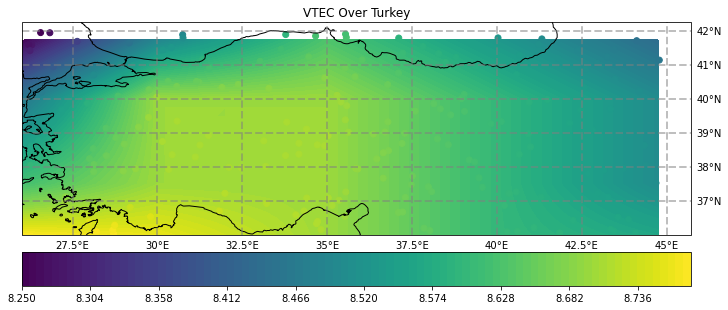

In [2]:
# General Code, create grid for Turkey, load dataset.

#Berk Kıvılcım
#21632734

# You are given a dataset created for your own ID.
# 
# The dataset contains:
#  grid_X : a grid of longitudes over Turkey
#  grid_Y : a grid of latitudes over Turkey
#  grid_vtec : a grid of Vertical Total Electron Content over Turkey 
#              corresponding to the longitude and latitude grid
#  lons   : longitudes of your measurement locations
#  lats   : latitudes of your measurement locations
#  vtec   : Vertical Total Electron Content corresponding to measurement locations

# You have a set of measurements for Vertical Total Electron Content for specific locations
# In addition you are also provided with a grid of longitudes and latitudes for which the True VTEC is given.

import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#
# A Class to represent your dataset
#
class IonoData(object):
    def __init__(self, fname):
        with np.load(fname) as data:
            self.grid_X = data['grid_X']
            self.grid_Y = data['grid_Y']
            self.grid_vtec = data['grid_vtec']
            self.lons = data['lons']
            self.lats = data['lats']
            self.vtec = data['vtec']

            
#
# A utility function to plot resulting maps, differences, residuals or measurements
#
def plot_grid(X,Y,Z, title='VTEC Over Turkey',lons=None,lats=None, vtecs=None):
    plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    plt.title(title)
    cf = ax.contourf(X,Y,Z,100)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    plt.colorbar(cf, ax=ax,orientation="horizontal", pad=0.04)
    
    # Plot point data over the figure
    if lons is not None:
        ax.scatter(lons,lats,c=vtecs)

# Load your datset
data = IonoData('hw2_datasets/21632734/ds.npz')

#Half of the data 
#To compare the results. This code must re-run for compare 
#There is 200 points and python index starts from zero
#data.lons=data.lons[0:(200//2)]
#data.lats=data.lats[0:(200//2)]
#data.vtec=data.vtec[0:(200//2)]

# Plot ground truth
plot_grid(data.grid_X,data.grid_Y,data.grid_vtec, lons=data.lons,lats=data.lats,vtecs=data.vtec)


# TASK 1: Trend Surface Analysis

Complete the following code to plot a trend surface analysis and residuals over the Turkey, and compare your result visually with the above figure.

Here we assume that VTEC over Turkey have the following mathematical model

$$
vtec(\lambda, \theta) = \beta_0 + \beta_1 \lambda + \beta_2 \theta + \beta_3 \lambda \theta + \beta_4 \lambda^2 + \beta_5 \theta ^2 
$$

where $\lambda$ is longitude and $\theta$ is latitude in degrees. $\beta_i, i=0,1,....$ are the parameters of the model.

We form a least squares estimation of parameters $\beta_i$ as:

$$
\boldsymbol{y} = \boldsymbol{X}\boldsymbol{\beta}
$$

where $\boldsymbol{y}$ contains vtec measurements provided in your dataset. Namely, **data.vtec**, also recall that your data also contains longitude (**data.lons**) and latitude (**data.lats**) of the measurements.

the parameters can be estimated as

$$
\boldsymbol{\hat{\beta}} = \boldsymbol{(X^TX)^{-1}X^Ty}
$$

where you may directly use numpy routine lstsq.

The residuals can be calculated by:
$$
\boldsymbol{r} = \boldsymbol{X}\boldsymbol{\hat{\beta}}
$$

The grid can be calculated by forming the design matrix $X_{grid}$. Then estimated VTEC at the grid may be calculated as:

$$
\boldsymbol{\hat{y_{grid}}} = \boldsymbol{X_{grid}}\hat{\boldsymbol{\beta}}
$$

where $\boldsymbol{\hat{y_{grid}}}$ are estimated VTEC at grid locations.

Or alternatively, you may directly use the estimated parameters in the functional model for any given location

$$
vtec(\lambda_i, \theta_i) = \hat{\beta_0} + \hat{\beta_1} \lambda_i + \hat{\beta_2} \theta_i + \hat{\beta_3} \lambda_i \theta_i + \hat{\beta_4} \lambda_i^2 + \hat{\beta_5} \theta_i^2 
$$


Complete the following code and plot estimated grid with residuals of VTEC over Turkey.


Estimated parameters are :  [ 3.44271314e+00  1.54976226e-02  2.85710655e-01  3.10297231e-03
 -1.98467197e-03 -5.41951722e-03]


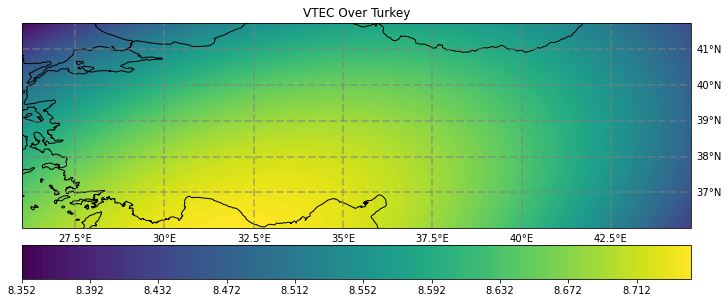

In [25]:
# the measurement vector of VTEC is already given
y = data.vtec

#with associated longitudes
lons = data.lons

#and latitudes
lats = data.lats

# construct design matrix

X = np.vstack(
    [
        np.ones_like(lons), # the first column contains the coefficients of beta_0
        lons,
        lats,
        lats*lons,
        lons*lons,
        lats*lats
    ]
).T

betas = np.linalg.lstsq( X, y, rcond=None)[0]

print ("Estimated parameters are : ", betas)

#Lets create the grid values of estimated VTEC

grid_ts = betas[0] + betas[1]*data.grid_X + betas[2]*data.grid_Y + betas[3]*data.grid_X * data.grid_Y + betas[4]*data.grid_X**2 + betas[5]*data.grid_Y**2

plot_grid(data.grid_X,data.grid_Y, grid_ts)

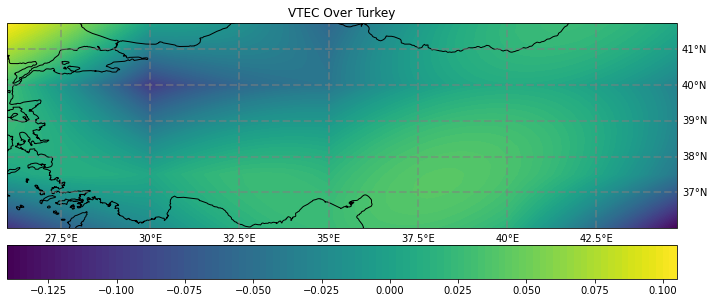

In [26]:
## Plot difference between estimated trend surface and ground truth in the dataset
plot_grid(data.grid_X, data.grid_Y, grid_ts-data.grid_vtec)


min-0.10052406102407119
max0.10850594915691758
mean-1.4619416788264062e-14
std0.033729521859979655


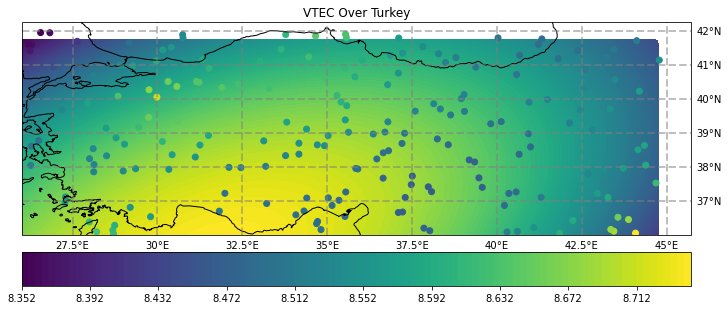

In [27]:
## Calculate residuals of the analysis

residuals = y - np.dot(X,betas)

## Print statistics of residuals (min, max, mean, std)
print("min" + str(residuals.min()))
print('max'+str(residuals.max()))
print("mean"+str(residuals.mean()))
print("std"+str(residuals.std()))
# Plot residuals over Trend Surface
plot_grid(data.grid_X,data.grid_Y, grid_ts, lons=lons, lats=lats, vtecs= residuals)


## Comments for TASK 1

!!! Please write your comments for TASK1 here

In [28]:
#Firstly I need to download python libraries. Libraries already downloaded except cartopy so I download it with anaconda promt 
#with "conda install -c conda-forge cartopy" command.
#To fill the ? blanks I must understand the formulas. The second degree polynomial equation made by latitude and longtitude given 
#Longtitude is lambda and latitude is teta. With this equation we create our A matrix for least square adjustment.
#A matrix named by X. That six parameters matrix which is include  lons,lats,lats*lons,lons*lons,lats*lats as parameters
#Then we use numpy's Least square adjustment function with X and y matrices. That gives estimated parameters for estimated vtec
#Then we plot estimated vtec parameters. 
#Lastly we get the differences of estimated and grand truth. I understand "data.grid_vtec" was ground truth. It given in prerequites
#section.
#Also residuals formulas given above here and we calculate and illustrate it with their statistics.
#Residuals not disturbest randomly, beside it is homogenous. I understand it from points and their colors.

# TASK 2 : Ordinary Kriging

Apply ordinary kriging interpolation to the dataset. For this, you first calculate an experimental variogram for the measurements, then apply kriging interpolation from Field Analysis lecture to calculate the estimated VTEC at grid locations.

Note: Do not forget to give comments when necessary.

1. Variogram Model Selection
2. Interpolation at grid positions
3. Producing Error Map

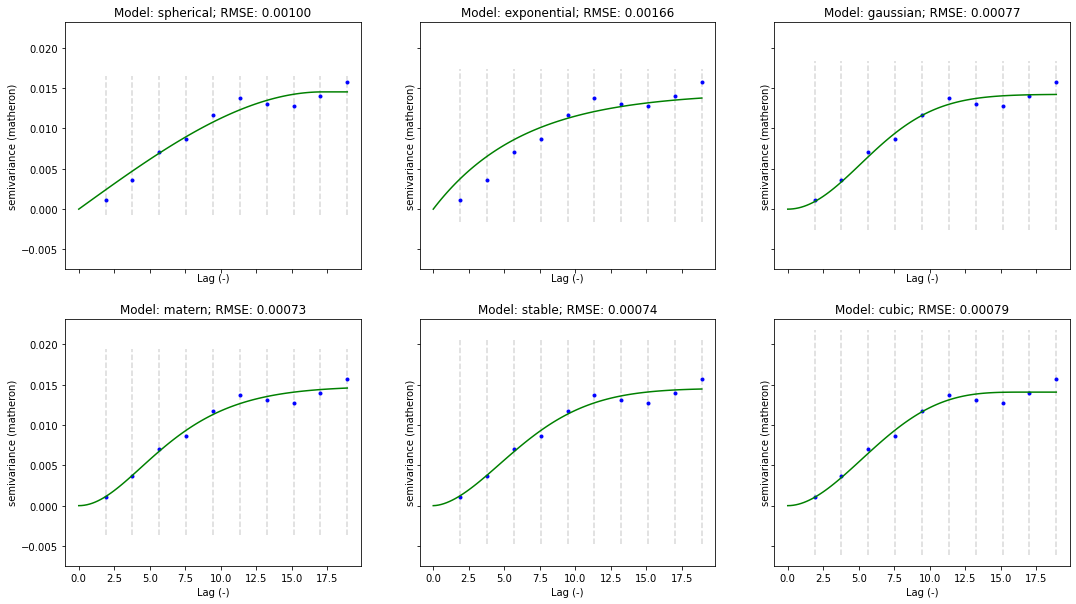

In [29]:
## Create variogram model of the residuals
from skgstat import Variogram, OrdinaryKriging

V1 = Variogram(np.vstack((lons, lats)).T, data.vtec, normalize=False)
fig, _a = plt.subplots(2,3, figsize=(18, 10), sharex=True, sharey=True)
axes = _a.flatten()


for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    
    V1.model = model
    
    V1.plot(axes=axes[i], hist=False, show=False)
    
    axes[i].set_title('Model: %s; RMSE: %.5f' % (model, V1.rmse))

## Looking at the different mathematical models for experimental variogram, which variogram model shall you choose and why?



Discuss here

In [30]:
# Interpolate for the grid in your data
def interpolate(V, X, Y):
    ok = OrdinaryKriging(V, min_points=5, max_points=15, mode='exact')
    field = ok.transform(X.ravel(), Y.ravel())
    
    field = field.reshape(-1,76)
    field_sigma = ok.sigma.reshape(-1,76)
    #Shapes of x (24, 76) and z (1824, 1) 
    #We must reshape one dimensional z equal with x. So (-1,76 parameters selected.)
    #That parameters make z array turn to (24,76) matrix
    #where -1 infers the size of the new dimension from the size of the input array.
    return field,field_sigma
V = Variogram(np.vstack((lons, lats)).T, data.vtec, normalize=False)
V.model = 'matern'
    #matern model selected because it has smallest rms error. Less errors means better solution
krig_vtec,krig_err = interpolate(V,data.grid_X,data.grid_Y)



C:\Users\user\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\user\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


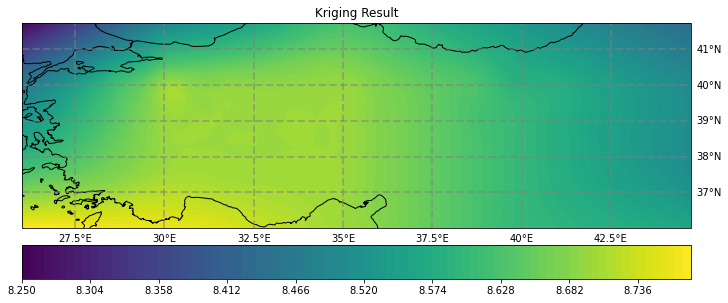

In [31]:
# Plot interpolated kriging grid
plot_grid(data.grid_X,data.grid_Y,krig_vtec, title='Kriging Result')

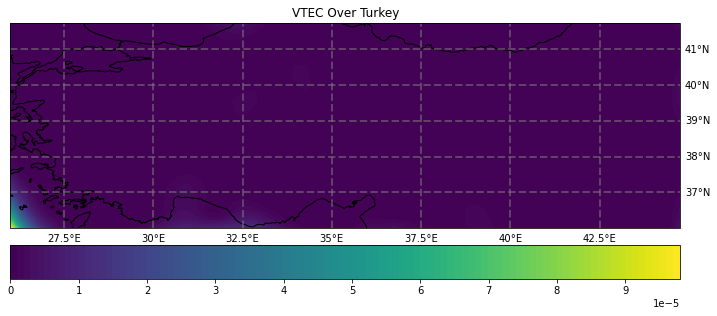

In [32]:
# Plot Kriging Error Map

plot_grid(data.grid_X,data.grid_Y,krig_err)

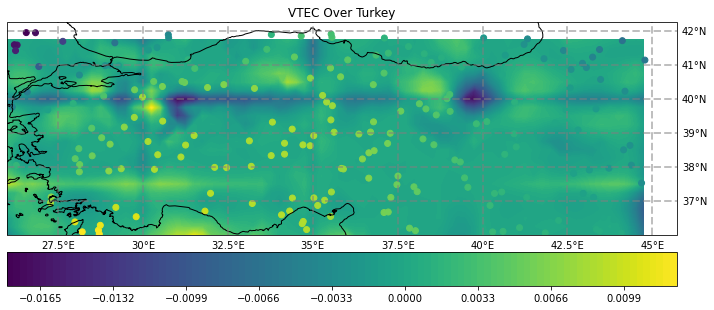

In [33]:
# Plot differences between Kriging interpolation and ground truth, show also data distribution

plot_grid(data.grid_X,data.grid_Y,krig_vtec - data.grid_vtec,lons=lons,lats=lats,vtecs=data.vtec)

# TASK 3 Compare Kriging with Trend Surface Analysis

1. Using the plots of differences with respect to ground truth data, discuss whether Polynomial Trend Surface analysis or Kriging interpolation is more suitable with the dataset.

2. What would happen when data is not well distributed over Turkey? Assume there are huge gaps between data points? What would be the results then? Calculate the results by only using the half of the dataset and compare your results again?

3. Discuss in which kind of problems you would prefer Trend Surface analysis over Kriging?

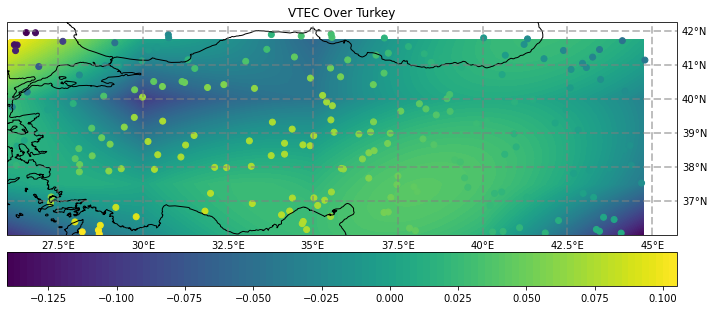

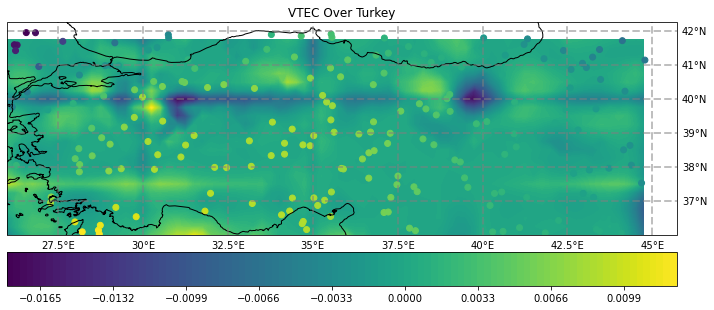

In [34]:
## Code for Task3 goes here
plot_grid(data.grid_X,data.grid_Y, (grid_ts-data.grid_vtec), lons=lons, lats=lats, vtecs=data.vtec )
plot_grid(data.grid_X,data.grid_Y, (krig_vtec-data.grid_vtec), lons=lons, lats=lats, vtecs=data.vtec )

#1.
#The most significant change between TSA (trend surface analysis) and kriging is change rates.
#It is clearly seen TSA slightly changed however kriging method sharply changes.
#This situation caused by tobler's first law. To exemplfy it TSA does not count this law very well. In the other hand
#Kriging handle this law very well. In TSA extreme values negleted so changes so smooth.
#AS RESULT I WOULD CHOOSE KRIGING BECAUSE THERE İS A HUGE EFFECT TOBLER EFFECT IN "GUMUSHANE". THIS EFFECT SHOULDN'T BE NEGLETED

#2.
#Data shrinking done in prerequisites section. It indicated with comments. Also to apply it comments in front of the reducer 
#functions must be delete first. Then re-run all of things to apply everything to shrunk data.
#After the banish half of the datas rmse error dramatically increased which is almost doubled. Still lowest rmse error belongs
#to matern but it increased 0.00073 to 0.00143
#After we reduce datas PCA not changed so much but kriging changed. Kriging looks more smooth. In my opinion the less data
#cause less neighbour effects. Thats the reason why kriging become more smooth. 

#3.
#I will prefer TSA in some spesific situations like low varianced areas or small working fields. In other situations kriging
#would be better because kriging include neighbour's weights more than TSA. Also if we don't know the attributes of points
#kriging would be much better.


# TASK 4

Discuss the Tobler's first law of Geography and its application to various spatial analysis methods covered in the class.


In [35]:
#Tobler's first law of Geography says that;
#"Everything is related to everything else, but near things are more related than distant things."

#Definitely I agree with that law. Distance things can also effect something but closer thing's effects would be more.
#This situation could apply many areas and fields because that's really general and proper definition. 
#Also in this assignment we can prove that effect.

#As we can see above in this assignment; 
#When we didn't include the neighbours effect with TSA; It is obvious everything affect and slightly changes each others.
#In the other side of the coin; when we take neighbour effect serious with kriging, neighbour's effect is tremendous 
#and some changes are very huge in close distance.
#This is a huge proof of the Tobler's First law.

#Morans-I is good spatial analysis method that fit tobler's first law. Morans-I could be used on corona density analysis according
#to Turkey's cities. This algorithm calculate a correlation result with weighted matrices which is generated by cities and their neighbours.

